# RBC model


> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **model analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `modelproject.py` file includes a function which could be used multiple times in this notebook.

Imports and set magics:

In [1]:
# 1. We import the packages
import numpy as np
from scipy import optimize
import sympy as sm
import pandas as pd
import matplotlib.pyplot as plt

# Autoreloads modules when code is run
#%load_ext autoreload
#%autoreload 2

# We import the local modules
from modelproject import NumericalSolution
from modelproject import SteadyStatePlot
from modelproject import NumericalSolutionCES

# Model description

 **RBC Model Setup - Assumptions** 

- Time is discrete,  $t\in\{0,1,2, \dots\}$.

- Large numbers of identical price-taking firms.

- Large numbers of identical price-taking households.

- Households are infinitely lived.

**The benevolent social planner solves the optimal growth problem:**
$c_t$ is consumption, $l_t$ is leisure for the household, $n_t$ is hours worked, $l_t$ is leisure, and $k_t$ is capital.
$$
\begin{aligned}
    \max_{\{c_t,n_t,k_{t+1}\}^{\infty}_{t=0}} &\mathbb{E}_0 \sum^{\infty}_{t=0} \beta^t u\left(c_t, n_t\right), \quad \beta \in (0,1) \\

    &\text{s.t.}\\
    \tag{1}
\end{aligned}
$$
Workhours-leisure constraint: 
$$
\begin{aligned}
    n_t + l_t = 1 \tag{2}
\end{aligned} \\
$$
Technology:
$$
\begin{aligned}
    y_t = A_t F(k_t,n_t) \tag{3}
\end{aligned} \\
$$
The resource constraint:
$$
\begin{aligned}
    y_t = c_t + i_t \tag{4}
\end{aligned} \\
$$
Capital accumulation:
$$
\begin{aligned}
    k_{t+1} = i_t + (1 - \delta) k_t \tag{5}
\end{aligned}
$$

The production function is Cobb-Douglas:

\begin{aligned}
F(k_t,n_t) = k_t^\alpha n_t^{1-\alpha} \tag{6}
\end{aligned}

The utility function:

\begin{aligned}
    u(c_t,n_t)=\log{\left(c_t\right)}+\psi l_t \tag{7}
\end{aligned}

### **Steady state equations**:

Steady state consumption
$$
\begin{equation}
    u_c(c,l) = \beta u_c(c,l)[1-\delta + AF_k(k,n)] \tag{13}
\end{equation}
$$

Steady-state capital-labour ratio:
$$
\begin{equation}
    \dfrac{k}{n} = \left[\dfrac{\alpha A }{\beta^{-1} - 1 + \delta}\right]^{1 - \alpha} \tag{14}
\end{equation}
$$

Law of motion for capital:
$$
\begin{equation}
    i = \delta k \tag{15}
\end{equation}
$$

Resource contraint in Steady State:
$$
\begin{equation}
    \dfrac{c}{n} = A\left(\dfrac{k}{n}\right)^{\alpha} - \delta \left(\dfrac{k}{n}\right) \tag{16}
\end{equation}
$$

Labour in Steady State:
$$
\begin{equation}
    \dfrac{c}{n} = A \dfrac{1 - \alpha}{\theta} \dfrac{1 - n}{n}\left(\dfrac{k}{n}\right)^{\alpha} \tag{17}
\end{equation}
$$

## Numerical solution

### Linear approxmiations

Before we can numerically solve the model then we need to *log linearize* around the steady state. This is because the RBC model is a non-linear model then we have to linerazise around the steady state. Otherwise, it will be harder to solve numerically.

In addition, we *log linearize* because it is easier to interpret percentages instead of units. Before we move on, the theory behind linear approxmiation is introduced to make sure the process is clear. The theory is from Alexandre Kohlhas' Macroeconomics III slides.

The total derivative of $f(x)$ at the steady state level for a vector of variables $x = x_t^*$:

$$
\begin{aligned}
    \text{df}(x_t) = \sum^n_{j=1} \dfrac{\partial f(x_t)}{\partial x_j}_{|x_t=x^*} dx_j \tag{18}
\end{aligned}
$$

So, total differentiation is approxmiately a Taylor approximation of first-order.

### Log-Linearization

The change in our variables is given by:
$$
\begin{aligned}
    f(x_t) &= f(y_t, c_t, i_t, n_t, l_t, k_t)\\
    &= f(\exp^{\log\left(y_t\right)}, \exp^{\log\left(c_t\right)}, \exp^{\log\left(i_t\right)}, \exp^{\log\left(n_t\right)}, \exp^{\log\left(l_t\right)}, \exp^{\log\left(k_t\right)}) 
\end{aligned}
$$

Total differentiation in log-linear systems is:

$$
\begin{aligned}
    df(x_t) = \sum^n_{j=1} \left(\dfrac{\partial f(x_t)}{\partial x_j} \cdot \exp^{\log\left(x_j\right)}_{|x_t = x^*}\right) \cdot d \log{\left(x_j\right)} 
\end{aligned}
$$

Our system of equations is:

$$
\begin{aligned}
    \begin{pmatrix}
        \psi c_t\\
        \dfrac{1}{c_t}\\
        y_t\\
        y_t\\
        k_{t+1}\\
        1
    \end{pmatrix} = \begin{pmatrix} 
        (1 - \alpha) z_t \left(\dfrac{k_t}{n_t}\right)^{\alpha}\\
        \beta \mathbb{E}_t \left[\dfrac{1}{c_{t+1}}\left(\alpha A_{t+1} \left(\dfrac{k_{t+1}}{n_{t+1}}\right)^{\alpha-1}\right) + (1 - \delta)\right]\\
        A_t k_t^{\alpha}n_t^{1-\alpha}\\
        y_t = c_t + i_t\\
        (1-\delta)k_t + i_t\\
        1 + l_t + n_t
    \end{pmatrix}
\end{aligned}
$$

To numerically solve the RBC model, we define a system of variables:

$$
    x_t = \begin{pmatrix} 
    \text{Output}\\
    \text{Consumption}\\
    \text{Investment}\\
    \text{Labour}\\
    \text{Leisure}\\
    \text{Capital}\\
    \end{pmatrix}\\ 
    = \begin{pmatrix}
    y_t \\
    c_t\\
    i_t\\
    n_t\\
    l_t\\
    k_t\\
    \end{pmatrix} 
$$

Next, we define a paramter space, $\Theta$:

$$
    \Theta = \begin{pmatrix} 
        \text{Discount rate}\\
        \text{Marginal disutility of labour}\\
        \text{Depreciation rate}\\
        \text{Capital-share of output}\\
        \text{Technology}
    \end{pmatrix}\\
    = \begin{pmatrix}
        \beta\\
        \theta\\
        \delta\\
        \alpha\\
        A
    \end{pmatrix}\\
    \approx \begin{pmatrix}
        0.9\\ 
        3\\ 
        0.1\\ 
        1/3\\
        1
    \end{pmatrix} 
$$

### Root finding algorithm

We use a root finding algorithm to find the steady state values in the RBC-model. In this subsection, we describe how it works.

$$
    f(x_{t+1}, x_t) = 0 
$$

$$
    \log{\left(f_1\left(e^{\log{(x_{t+1})}}, e^{\log{(x_t)}}\right)\right)} - \log{\left(f_2\left(e^{\log{(x_{t+1})}}, e^{\log{(x_t)}}\right)\right)} = 0 
$$

#### The Log-linearized system of equations  

In this subsection, we write the equations down that we will evalute in the root finding algorithm. We set the equations equal to zero, as we want to find the steady state values.

$$
\begin{aligned}
    \log{\left(\psi\right)} + \log{\left(c_{t+1}\right)} - \log{\left(1 - \alpha \right)} - \log{A} - \alpha \cdot \left(\log{c_{t+1}} - \log{n_{t+1}}\right) 
\end{aligned}
$$
For the consumption euler equation:
$$
\begin{aligned}
    \beta \mathbb{E_t} \left[\dfrac{1}{c_{t+1}}\left(\alpha A \left(\dfrac{k_{t+1}}{n_{t+1}}\right)^{\alpha-1}\right) + (1 - \delta)\right] &= \dfrac{1}{c_t}\\
    \dfrac{1}{c_t} - \beta \mathbb{E_t} \left[\dfrac{1}{c_{t+1}}\left(\alpha A \left(\dfrac{k_{t+1}}{n_{t+1}}\right)^{\alpha-1}\right) + (1 - \delta)\right] &= 0\\
    - \log(c_t) - \mathbb{E_t}\left[\log(\beta) + \log(c_{t+1}) - \log\left(\dfrac{\alpha A \cdot e^{1 - \alpha} \cdot \log(n_{t+1})}{e^{1 - \alpha} \cdot \log(k_{t+1})} \right) + (1-\delta)\right] &= 0 
\end{aligned}
$$
For the Cobb-Douglas production function:
$$
\begin{aligned}
    \log{\left(y_{t+1}\right)} - \log{(A)} - \alpha \cdot \log{\left(k_{t+1}\right)} - (1 - \alpha) \cdot \log{\left(\log{\left(n_{t+1}\right)}\right)} 
\end{aligned}
$$
For the resource constraint:
$$
\begin{aligned}
    y_{t+1} &= c_{t+1} + i_{t+1}\\
    y_{t+1} - c_{t+1} - i_{t+1} &= 0\\
    \log{\left(y_{t+1}\right)} - \log{\left(c_{t+1}\right)} - \log{\left(i_{t+1}\right)} &= 0\\
    \log{\left(y_{t+1}\right)} - \log{\left(e^{\log{\left(c_{t+1}\right)}} + e^{\log{\left(i_{t+1}\right)}}\right)} &= 0 
\end{aligned}
$$
For capital accumulation: 
$$
\begin{aligned}
    k_{t+1} &= (1-\delta)k_t + i_t\\
    k_{t+1} - (1-\delta)k_t - i_t &= 0 \\
    \log{\left(k_{t+1}\right)} - \log{\left(e^{\log{\left(i_t\right)}} + (1-\delta) \cdot e^{\log{\left(k_t\right)}}\right)} &= 0 
\end{aligned}
$$
For the labour-leisure constraint:
$$
\begin{aligned}
    n_{t+1} + i_{t+1} &= 1\\
    1 - n_{t+1} - i_{t+1} &= 0\\
    - \log{\left(e^{\log{\left(n_{t+1}\right)}} + e^{\log{\left(i_{t+1}\right)}}\right)} &= 0 
\end{aligned}
$$

In [2]:
# 1. Saves the names for the variables
variables = [
    'Output', 'Consumption', 'Investment',
    'Labour', 'Leisure', 'Capital'
]

# 2. Saves the names for the parameters
parameters = [
    'Discount rate', 'Disutility of labor',
    'Depreciation rate', 'Capital share', 'Technology'
]

In [3]:
# 1. We give some reasonable parameter values for our parameters in the Real Business Cycle Model
parameter_values = pd.DataFrame({
    # a. The names for the variables
    'Name': parameters,
    # b. The values for the variables
    'Value': [0.9, 3, 0.1, 1/3, 1]
})

# 2. Rounds the decimals to only one decimal
parameter_values['Value'] = parameter_values['Value'].round(1)

# 3. Shows the parameter values
parameter_values.T

,0,1,2,3,4
Name,Discount rate,Disutility of labor,Depreciation rate,Capital share,Technology
Value,0.9,3.0,0.1,0.3,1.0


In [4]:
# 1. Create an instance of the class for maximizing the roots
numericsolution = NumericalSolution(parameter_values['Value'])

# 2. Store the steady state values in a DataFrame
steady_state_values = pd.DataFrame({
    # a. Set up the row for the values
    'Steady state value': numericsolution.steady_state_numeric()
    # b. Set up the columns for the variables
}, index=variables)

# 3. Round the number of decimals to be two
steady_state_values['Steady state value'] = steady_state_values['Steady state value']

# 4. A print statement for the table
print("The table for the steady state values for the variables can be seen below:")

# 5. Show the steady state values 
steady_state_values.T

The table for the steady state values for the variables can be seen below:


,Output,Consumption,Investment,Labour,Leisure,Capital
Steady state value,0.859492,0.737353,0.122138,0.739328,0.260672,1.221383


#### Plot for the steady state values

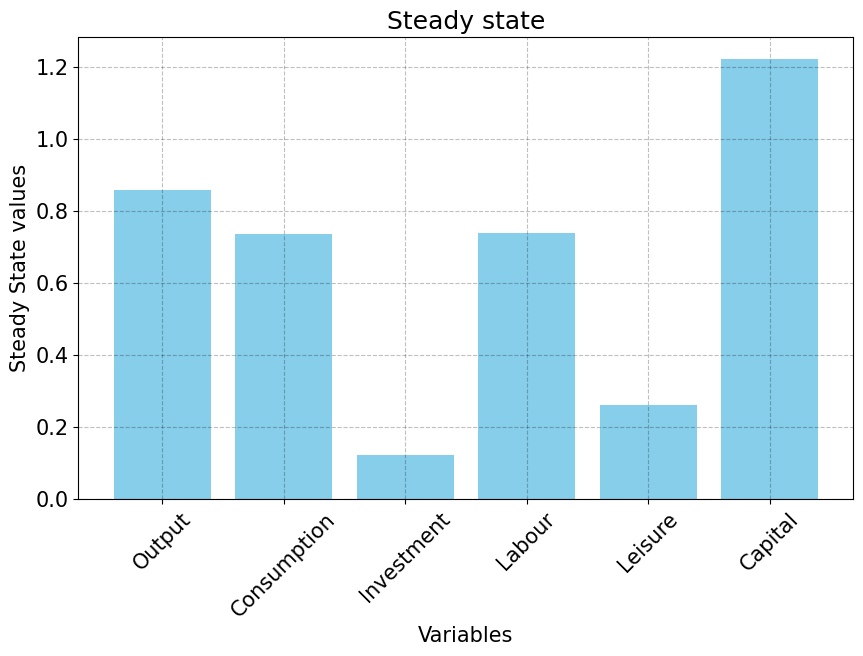

In [5]:
# 1. We create an instance of the class
simpleplot = SteadyStatePlot(variables, steady_state_values)

# 2. We plot the steady state values in a simple plot
simpleplot.simpleplot()

### An extension of the model

Our model extension involves replacing the Cobb-Douglas production function with a Constant Elasticity of Substitution (CES) function. This modification allows us to explore how the steady-state values change when capital and labor are no longer assumed to be perfect substitutes.

CES production function:
\begin{equation}
    y_t = [\alpha k_t^{\rho} + (1 - \alpha )n_t^{\rho}]^{\frac{1}{\rho}}
\end{equation}

In [6]:
# 1. We redefine the parameters and variables by including 'rho'
parameters_CES = ['Discount rate', 'Disutility of labor', 'Depreciation rate', 'Capital share', 'Technology', 'rho']

# 2. Store the steady state values in a Pandas DataFrame
parameter_values_ces = pd.DataFrame({
    'name': parameters_CES,
    'value': [0.9, 3, 0.1, 1/3, 1, 0.5]
})

# 3. Create an instance of the class for maximizing the roots in the extended model
numericsolutionces = NumericalSolutionCES(parameter_values_ces['value'])

# 4. Store the steady state values for the extended model in a DataFrame
steady_state_values_CES = pd.DataFrame({
    'value': numericsolutionces.steady_state_numeric()
}, index=variables)

# 5. Show the steady state values for the extended model
print("The table for the steady state values for the variables can be seen below:")
steady_state_values_CES.T

The table for the steady state values for the variables can be seen below:


,Output,Consumption,Investment,Labour,Leisure,Capital
value,0.896886,0.759042,0.137844,0.694765,0.305235,1.378444


# Conclusion

The numerical analysis of the simple RBC model, using the Cobb-Douglas production function and its extension of the CES production function, shows that, generally, steady-state values are lower for the RBC model employing the Cobb-Douglas function compared to when the CES function is used, with labor being the exception.